В данных 54 магазина и 33 семейства продуктов.                     
Временной ряд тренировочных данных с 01.01.2013 по 15.08.2017.              
Временной ряд тестовых данных для submition составляет 16 дней после последней даты тренировочных данных: с 16.08.2017 по 31.08.2017.                   
                                 
Нужно составить прогноз продаж для каждого семейства продуктов и комбинаций магазинов.           
                                
**В соревновании представлены 6 датасетов**                   
1. Train содержит временные ряды магазинов (столбец store_nbr) и комбинации семейств продуктов(столбец family). Столбец sales показывает общий объем продаж семейства продуктов в конкретном магазине на указанную дату. Столбец onpromotion показывает общее количество продуктов в семействе продуктов, которые продвигались в магазине, на заданную дату.
2. Test - данные на тестовый период для submition.
3. Store - дает некоторую информацию о магазинах, таких как город, штат, тип, кластер.
4. Transactions - сильно коррелирует с колонкой sales из тренировочных данных. Помогает понять схемы продаж в магазинах.
5. Holidays and Events - метаданные. Дают информацию о праздниках. 
6. Daily Oil Price - цена на нефть.

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import warnings

# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')
%matplotlib inline
from tqdm.auto import tqdm

# 1. Import Data

In [2]:
# Import
train = pd.read_csv("../input/store-sales-time-series-forecasting/train.csv")
test = pd.read_csv("../input/store-sales-time-series-forecasting/test.csv")
stores = pd.read_csv("../input/store-sales-time-series-forecasting/stores.csv")
#sub = pd.read_csv("../input/store-sales-time-series-forecasting/sample_submission.csv")   
transactions = pd.read_csv("../input/store-sales-time-series-forecasting/transactions.csv").sort_values(["store_nbr", "date"])


# Datetime
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)

# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

### train & test

In [3]:
train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE   0.00         0.00
1   1 2013-01-01          1   BABY CARE   0.00         0.00
2   2 2013-01-01          1      BEAUTY   0.00         0.00
3   3 2013-01-01          1   BEVERAGES   0.00         0.00
4   4 2013-01-01          1       BOOKS   0.00         0.00

In [4]:
train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           3000888 non-null  int64         
 1   date         3000888 non-null  datetime64[ns]
 2   store_nbr    3000888 non-null  int64         
 3   family       3000888 non-null  object        
 4   sales        3000888 non-null  float32       
 5   onpromotion  3000888 non-null  float16       
dtypes: datetime64[ns](1), float16(1), float32(1), int64(2), object(1)
memory usage: 108.8+ MB


In [5]:
# train['family'] = train['family'].astype('category')
# train['family_category'] = train['family'].cat.codes

In [6]:
test.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


### transactions

In [7]:
transactions.head(10)

date  store_nbr  transactions
1   2013-01-02          1          2111
47  2013-01-03          1          1833
93  2013-01-04          1          1863
139 2013-01-05          1          1509
185 2013-01-06          1           520
231 2013-01-07          1          1807
277 2013-01-08          1          1869
323 2013-01-09          1          1910
369 2013-01-10          1          1679
415 2013-01-11          1          1813

In [8]:
temp = pd.merge(train.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions, how = "left")
print("Spearman Correlation between Total Sales and Transactions: {:,.4f}".format(temp.corr("spearman").sales.loc["transactions"]))
px.scatter(temp, x = "transactions", y = "sales", trendline = "ols", trendline_color_override = "red")

Spearman Correlation between Total Sales and Transactions: 0.8175


<AxesSubplot:title={'center':'sales - year'}, xlabel='year'>

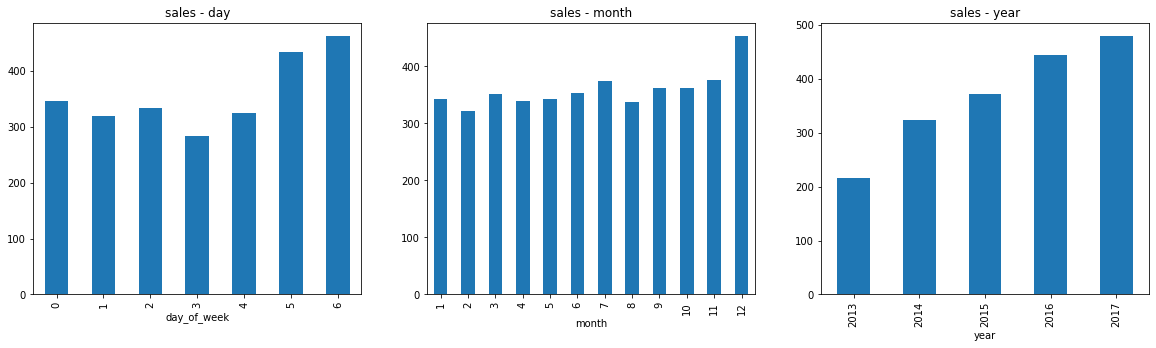

In [9]:
train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

data_grouped_day = train.groupby(['day_of_week']).mean()['sales']
data_grouped_month = train.groupby(['month']).mean()['sales']
data_grouped_year = train.groupby(['year']).mean()['sales']

plt.subplots(3,1, figsize=(20,5))
plt.subplot(131)
plt.title('sales - day')
data_grouped_day.plot(kind='bar', stacked=True)
plt.subplot(132)
plt.title('sales - month')
data_grouped_month.plot(kind='bar', stacked=True)
plt.subplot(133)
plt.title('sales - year')
data_grouped_year.plot(kind='bar', stacked=True)

<AxesSubplot:title={'center':'transactions - year'}, xlabel='year'>

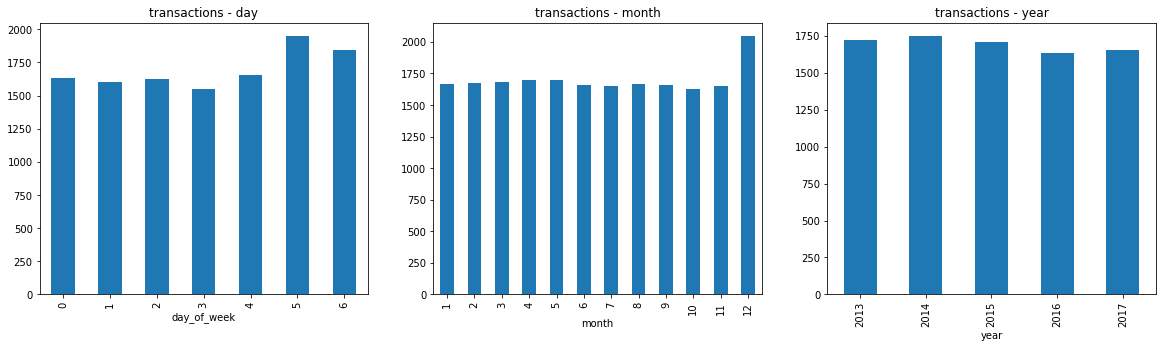

In [10]:
transactions['day_of_week'] = transactions['date'].dt.dayofweek
transactions['month'] = transactions['date'].dt.month
transactions['year'] = transactions['date'].dt.year

transactions_grouped_day = transactions.groupby(['day_of_week']).mean()['transactions']
transactions_grouped_month = transactions.groupby(['month']).mean()['transactions']
transactions_grouped_year = transactions.groupby(['year']).mean()['transactions']

plt.subplots(3,1, figsize=(20,5))
plt.subplot(131)
plt.title('transactions - day')
transactions_grouped_day.plot(kind='bar', stacked=True)
plt.subplot(132)
plt.title('transactions - month')
transactions_grouped_month.plot(kind='bar', stacked=True)
plt.subplot(133)
plt.title('transactions - year')
transactions_grouped_year.plot(kind='bar', stacked=True)

В Transaction существует стабильный паттерн: все месяцы аналогичны, кроме декабря с 2013 по 2017 год. Тот же паттерн наблюдается в продажах для каждого магазина: в конце года продажи увеличиваются.                       
Большая корреляция и логика говорят о том, что добавление транзакций в качестве фичи приведет к утечке данных и переобучению.  

In [11]:
# Добавляем в test аналогичные фичи
test['day_of_week'] = test['date'].dt.dayofweek
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year

### Oil Price

In [12]:
# Import 
oil = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv")
oil["date"] = pd.to_datetime(oil.date)

In [13]:
oil.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20

In [14]:
# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()
# Interpolate
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] =oil.dcoilwtico.interpolate()
# Plot
p = oil.melt(id_vars=['date']+list(oil.keys()[5:]), var_name='Legend')
px.line(p.sort_values(["Legend", "date"], ascending = [False, True]), x='date', y='value', color='Legend',title = "Daily Oil Price" )

Correlation with Daily Oil Prices
sales          -0.30
transactions    0.04
Name: dcoilwtico_interpolated, dtype: float64 



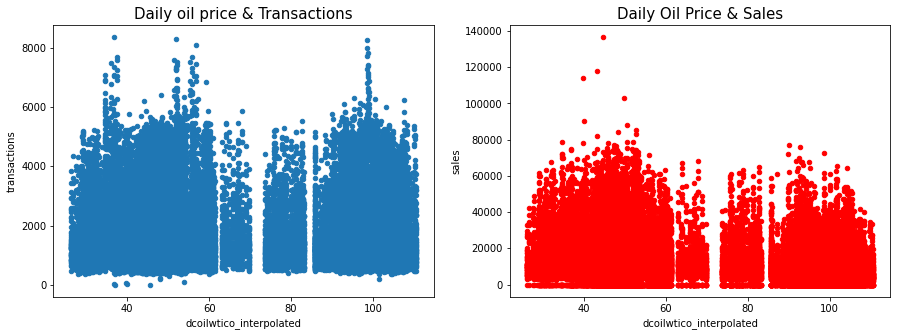

In [15]:
temp = pd.merge(train.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions, how = "left")
temp = pd.merge(temp, oil, how = "left")
print("Correlation with Daily Oil Prices")
print(temp.drop(["store_nbr", "dcoilwtico"], axis = 1).corr("spearman").dcoilwtico_interpolated.loc[["sales", "transactions"]], "\n")


fig, axes = plt.subplots(1, 2, figsize = (15,5))
temp.plot.scatter(x = "dcoilwtico_interpolated", y = "transactions", ax=axes[0])
temp.plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[1], color = "r")
axes[0].set_title('Daily oil price & Transactions', fontsize = 15)
axes[1].set_title('Daily Oil Price & Sales', fontsize = 15);

По логике вещей, если ежедневная цена на нефть высока, мы ожидаем, что экономика плохая, а значит цена на продукт растет, а продажи падают. Однако, здесь наблюдаем отрицательную корреляцию.                       
Тем не менее можем наблюдать еще один паттерн в поведении графиков: при цене на нефть ниже 70 продаж больше. Таким образом, имеем 2 кластера количества продаж: при цене на нефть ниже 70 и выше 70.         

In [16]:
oil['oil_over_70']=oil.dcoilwtico_interpolated.apply(lambda x: 1 if x>70 else 0)
oil = oil.set_index('date')
train = train.set_index('date')
train = train.join(oil.oil_over_70,how='left')
train=train.reset_index()

In [17]:
# для test
test = test.set_index('date')
test = test.join(oil.oil_over_70,how='left')
test = test.reset_index()

### Sales

Разберем sales более подробно.                           
Ниже приведен график, показывающий общий объем продаж за день.

In [18]:
a = train.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores")

В ходе анализа продаж выяснилось, что у некоторых из них нет продаж на начало 2013 года. Их можно увидеть, если посмотреть на эти магазины 20, 21, 22, 29, 36, 42, 52 и 53. Удалим эти строки.

In [19]:
print(train.shape)
train = train[~((train.store_nbr == 52) & (train.date < "2017-04-20"))]
train = train[~((train.store_nbr == 22) & (train.date < "2015-10-09"))]
train = train[~((train.store_nbr == 42) & (train.date < "2015-08-21"))]
train = train[~((train.store_nbr == 21) & (train.date < "2015-07-24"))]
train = train[~((train.store_nbr == 29) & (train.date < "2015-03-20"))]
train = train[~((train.store_nbr == 20) & (train.date < "2015-02-13"))]
train = train[~((train.store_nbr == 53) & (train.date < "2014-05-29"))]
train = train[~((train.store_nbr == 36) & (train.date < "2013-05-09"))]
train.shape

(3000888, 10)


(2780316, 10)

### Нулевые продажи в sales

Некоторые магазины не продают некоторые семейства продуктов. Выясним, какие продукты в каких магазинах не продаются. Их прогнозы должны быть равны 0 на следующие 16 дней.

Удалим их из данных и создадим датасет для семейств продуктов, которые никогда не продаются. При формировании submition, необходиом будет объединить этот фрейм данных с нашими прогнозами.

In [20]:
c = train.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
c = c[c.sales == 0]
c

store_nbr           family  sales
1             1        BABY CARE   0.00
397          13        BABY CARE   0.00
727          23        BABY CARE   0.00
1420         44        BABY CARE   0.00
1453         45        BABY CARE   0.00
1486         46        BABY CARE   0.00
1519         47        BABY CARE   0.00
1552         48        BABY CARE   0.00
1585         49        BABY CARE   0.00
1618         50        BABY CARE   0.00
1651         51        BABY CARE   0.00
1684         52        BABY CARE   0.00
268           9            BOOKS   0.00
301          10            BOOKS   0.00
334          11            BOOKS   0.00
367          12            BOOKS   0.00
400          13            BOOKS   0.00
433          14            BOOKS   0.00
466          15            BOOKS   0.00
499          16            BOOKS   0.00
532          17            BOOKS   0.00
565          18            BOOKS   0.00
598          19            BOOKS   0.00
631          20            BOOKS   0.00
664          21            BOOKS   0.00
697          22            BOOKS   0.00
895          28            BOOKS   0.00
928          29            BOOKS   0.00
961          30            BOOKS   0.00
994          31            BOOKS   0.00
1027         32            BOOKS   0.00
1060         33            BOOKS   0.00
1093         34            BOOKS   0.00
1126         35            BOOKS   0.00
1159         36            BOOKS   0.00
1258         39            BOOKS   0.00
1291         40            BOOKS   0.00
1390         43            BOOKS   0.00
1687         52            BOOKS   0.00
1753         54            BOOKS   0.00
514          16       LADIESWEAR   0.00
811          25       LADIESWEAR   0.00
910          28       LADIESWEAR   0.00
943          29       LADIESWEAR   0.00
1042         32       LADIESWEAR   0.00
1075         33       LADIESWEAR   0.00
1141         35       LADIESWEAR   0.00
1306         40       LADIESWEAR   0.00
1405         43       LADIESWEAR   0.00
1768         54       LADIESWEAR   0.00
449          14  LAWN AND GARDEN   0.00
977          30  LAWN AND GARDEN   0.00
1769         54  LAWN AND GARDEN   0.00

In [21]:
print(train.shape)
# Anti Join
outer_join = train.merge(c[c.sales == 0].drop("sales",axis = 1), how = 'outer', indicator = True)
train = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)
del outer_join
gc.collect()
train.shape

(2780316, 10)


(2698648, 10)

In [22]:
zero_prediction = []
for i in range(0,len(c)):
    zero_prediction.append(
        pd.DataFrame({
            "date":pd.date_range("2017-08-16", "2017-08-31").tolist(),
            "store_nbr":c.store_nbr.iloc[i],
            "family":c.family.iloc[i],
            "sales":0
        })
    )
zero_prediction = pd.concat(zero_prediction)
del c
gc.collect()
zero_prediction = zero_prediction.set_index(['store_nbr', 'family', 'date']).sort_index()
zero_prediction

sales
store_nbr family          date             
1         BABY CARE       2017-08-16      0
                          2017-08-17      0
                          2017-08-18      0
                          2017-08-19      0
                          2017-08-20      0
...                                     ...
54        LAWN AND GARDEN 2017-08-27      0
                          2017-08-28      0
                          2017-08-29      0
                          2017-08-30      0
                          2017-08-31      0

[848 rows x 1 columns]

# Feature engineering

### Активные и пассивные семейства продуктов

В пассивные определим семейства продуктов, которые не продавались в течение последних (перед периодом прогнозирования) 2 месяцев (60 дней)

In [23]:
c = train.groupby(["family", "store_nbr"]).tail(60).groupby(["family", "store_nbr"]).sales.sum().reset_index()
c[c.sales == 0]

family  store_nbr  sales
54                     BABY CARE          2   0.00
62                     BABY CARE         10   0.00
64                     BABY CARE         12   0.00
65                     BABY CARE         14   0.00
76                     BABY CARE         26   0.00
82                     BABY CARE         32   0.00
83                     BABY CARE         33   0.00
87                     BABY CARE         37   0.00
88                     BABY CARE         38   0.00
92                     BABY CARE         42   0.00
95                     BABY CARE         54   0.00
205                        BOOKS          2   0.00
206                        BOOKS          3   0.00
208                        BOOKS          5   0.00
209                        BOOKS          6   0.00
214                        BOOKS         25   0.00
215                        BOOKS         26   0.00
217                        BOOKS         37   0.00
219                        BOOKS         41   0.00
220                        BOOKS         42   0.00
229                        BOOKS         53   0.00
1014                  LADIESWEAR         36   0.00
1039             LAWN AND GARDEN         10   0.00
1041             LAWN AND GARDEN         12   0.00
1042             LAWN AND GARDEN         13   0.00
1043             LAWN AND GARDEN         15   0.00
1044             LAWN AND GARDEN         16   0.00
1045             LAWN AND GARDEN         17   0.00
1047             LAWN AND GARDEN         19   0.00
1050             LAWN AND GARDEN         22   0.00
1059             LAWN AND GARDEN         32   0.00
1060             LAWN AND GARDEN         33   0.00
1062             LAWN AND GARDEN         35   0.00
1621  SCHOOL AND OFFICE SUPPLIES          1   0.00
1622  SCHOOL AND OFFICE SUPPLIES          2   0.00
1626  SCHOOL AND OFFICE SUPPLIES          6   0.00
1636  SCHOOL AND OFFICE SUPPLIES         16   0.00
1643  SCHOOL AND OFFICE SUPPLIES         23   0.00
1644  SCHOOL AND OFFICE SUPPLIES         24   0.00
1652  SCHOOL AND OFFICE SUPPLIES         32   0.00
1653  SCHOOL AND OFFICE SUPPLIES         33   0.00
1660  SCHOOL AND OFFICE SUPPLIES         40   0.00
1674  SCHOOL AND OFFICE SUPPLIES         54   0.00

Посмотрим на некоторые из пассивных семейств продуктов

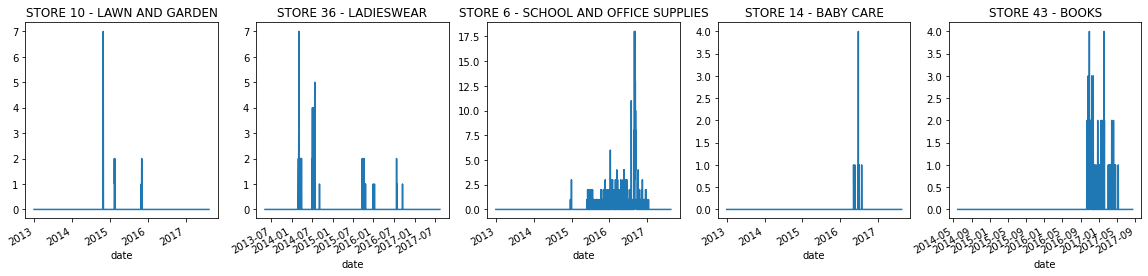

In [24]:
fig, ax = plt.subplots(1,5, figsize = (20,4))
train[(train.store_nbr == 10) & (train.family == "LAWN AND GARDEN")].set_index("date").sales.plot(ax = ax[0], title = "STORE 10 - LAWN AND GARDEN")
train[(train.store_nbr == 36) & (train.family == "LADIESWEAR")].set_index("date").sales.plot(ax = ax[1], title = "STORE 36 - LADIESWEAR")
train[(train.store_nbr == 6) & (train.family == "SCHOOL AND OFFICE SUPPLIES")].set_index("date").sales.plot(ax = ax[2], title = "STORE 6 - SCHOOL AND OFFICE SUPPLIES")
train[(train.store_nbr == 14) & (train.family == "BABY CARE")].set_index("date").sales.plot(ax = ax[3], title = "STORE 14 - BABY CARE")
train[(train.store_nbr == 53) & (train.family == "BOOKS")].set_index("date").sales.plot(ax = ax[4], title = "STORE 43 - BOOKS")
plt.show()

In [25]:
a=c[c.sales == 0]
a.columns = ['family', 'store_nbr', 'is_active_family']
a=a.set_index(['family', 'store_nbr'])
train=train.set_index(['family', 'store_nbr'])
train = train.join(a.is_active_family, how='left')
train.is_active_family=train.is_active_family.fillna(1)
train = train.reset_index()

In [26]:
# для test
test=test.set_index(['family', 'store_nbr'])
test = test.join(a.is_active_family, how='left')
test.is_active_family=test.is_active_family.fillna(1)
test =test.reset_index()

In [27]:
a = train.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
px.bar(a, y = "family", x="sales", color = "family", title = "Рейтинг продаж в разрезе семейст продуктов")

### stores

In [28]:
d = pd.merge(train, stores)
d["store_nbr"] = d["store_nbr"].astype("int8")
d["year"] = d.date.dt.year
px.line(d.groupby(["city", "year"]).sales.mean().reset_index(), x = "year", y = "sales", color = "city", title = "Продажи по городам")

In [29]:
px.line(d.groupby(["type", "year"]).sales.mean().reset_index(), x = "year", y = "sales", color = "type", title = "Продажи по типам магазинов")

In [30]:
px.line(d.groupby(["cluster", "year"]).sales.mean().reset_index(), x = "year", y = "sales", color = "cluster", title = "Продажи по кластерам магазинов")

In [31]:
px.line(d.groupby(["state", "year"]).sales.mean().reset_index(), x = "year", y = "sales", color = "state", title = "Продажи по регионам магазинов")

Продажи разнятся в разных городах, регионах, кластерах и типов магазинов. Добавим данные признаки.

In [32]:
train = pd.merge(train, stores, on='store_nbr', how='left')
# Для test
test = pd.merge(test, stores, on='store_nbr', how='left')

### holidays

In [33]:
holidays = pd.read_csv("../input/store-sales-time-series-forecasting/holidays_events.csv")
holidays["date"] = pd.to_datetime(holidays.date)
holidays

date        type    locale locale_name  \
0   2012-03-02     Holiday     Local       Manta   
1   2012-04-01     Holiday  Regional    Cotopaxi   
2   2012-04-12     Holiday     Local      Cuenca   
3   2012-04-14     Holiday     Local    Libertad   
4   2012-04-21     Holiday     Local    Riobamba   
..         ...         ...       ...         ...   
345 2017-12-22  Additional  National     Ecuador   
346 2017-12-23  Additional  National     Ecuador   
347 2017-12-24  Additional  National     Ecuador   
348 2017-12-25     Holiday  National     Ecuador   
349 2017-12-26  Additional  National     Ecuador   

                       description  transferred  
0               Fundacion de Manta        False  
1    Provincializacion de Cotopaxi        False  
2              Fundacion de Cuenca        False  
3        Cantonizacion de Libertad        False  
4        Cantonizacion de Riobamba        False  
..                             ...          ...  
345                      Navidad-3        False  
346                      Navidad-2        False  
347                      Navidad-1        False  
348                        Navidad        False  
349                      Navidad+1        False  

[350 rows x 6 columns]

In [34]:
# Transferred Holidays
tr1 = holidays[(holidays.type == "Holiday") & (holidays.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = holidays[(holidays.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
tr = pd.concat([tr1,tr2], axis = 1)
tr = tr.iloc[:, [5,1,2,3,4]]

holidays = holidays[(holidays.transferred == False) & (holidays.type != "Transfer")].drop("transferred", axis = 1)
holidays = holidays.append(tr).reset_index(drop = True)

# Additional Holidays
holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
holidays["type"] = np.where(holidays["type"] == "Additional", "Holiday", holidays["type"])

# Bridge Holidays
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays["type"] = np.where(holidays["type"] == "Bridge", "Holiday", holidays["type"])

# Work Day Holidays, that is meant to payback the Bridge.
work_day = holidays[holidays.type == "Work Day"]  
holidays = holidays[holidays.type != "Work Day"] 

In [35]:
# Split

# Events are national
events = holidays[holidays.type == "Event"].drop(["type", "locale", "locale_name"], axis = 1).rename({"description":"events"}, axis = 1)

holidays = holidays[holidays.type != "Event"].drop("type", axis = 1)
regional = holidays[holidays.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
national = holidays[holidays.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()
local = holidays[holidays.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"}, axis = 1).drop("locale", axis = 1).drop_duplicates()

In [36]:
# объединим тест и трейн в один датасет для удобства
d = train.append(test).copy()
d["store_nbr"] = d["store_nbr"].astype("int8")

In [37]:
# закодируем выходные и праздничные дни
# National Holidays & Events
#d = pd.merge(d, events, how = "left")
d = pd.merge(d, national, how = "left")
# Regional
d = pd.merge(d, regional, how = "left", on = ["date", "state"])
# Local
d = pd.merge(d, local, how = "left", on = ["date", "city"])

# Work Day: It will be removed when real work day colum created
d = pd.merge(d,  work_day[["date", "type"]].rename({"type":"IsWorkDay"}, axis = 1),how = "left")

# EVENTS
events["events"] =np.where(events.events.str.contains("futbol"), "Futbol", events.events)

def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    # categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    df.columns = df.columns.str.replace(" ", "_")
    return df, df.columns.tolist()

events, events_cat = one_hot_encoder(events, nan_as_category=False)
events["events_Dia_de_la_Madre"] = np.where(events.date == "2016-05-08", 1,events["events_Dia_de_la_Madre"])
events = events.drop(239)

d = pd.merge(d, events, how = "left")
d[events_cat] = d[events_cat].fillna(0)

# New features
d["holiday_national_binary"] = np.where(d.holiday_national.notnull(), 1, 0)
d["holiday_local_binary"] = np.where(d.holiday_local.notnull(), 1, 0)
d["holiday_regional_binary"] = np.where(d.holiday_regional.notnull(), 1, 0)

d["national_independence"] = np.where(d.holiday_national.isin(['Batalla de Pichincha',  'Independencia de Cuenca', 'Independencia de Guayaquil', 'Primer Grito de Independencia']), 1, 0)
d["local_cantonizacio"] = np.where(d.holiday_local.str.contains("Cantonizacio"), 1, 0)
d["local_fundacion"] = np.where(d.holiday_local.str.contains("Fundacion"), 1, 0)
d["local_independencia"] = np.where(d.holiday_local.str.contains("Independencia"), 1, 0)

holidays, holidays_cat = one_hot_encoder(d[["holiday_national","holiday_regional","holiday_local"]], nan_as_category=False)
d = pd.concat([d.drop(["holiday_national","holiday_regional","holiday_local"], axis = 1),holidays], axis = 1)

he_cols = d.columns[d.columns.str.startswith("events")].tolist() + d.columns[d.columns.str.startswith("holiday")].tolist() + d.columns[d.columns.str.startswith("national")].tolist()+ d.columns[d.columns.str.startswith("local")].tolist()
d[he_cols] = d[he_cols].astype("int8")

d[["family", "city", "state", "type"]] = d[["family", "city", "state", "type"]].astype("category")

del holidays, holidays_cat, work_day, local, regional, national, events, events_cat, tr, tr1, tr2, he_cols
gc.collect()

d.head(10)

family  store_nbr       date     id  sales  onpromotion  day_of_week  \
0  AUTOMOTIVE          1 2013-01-01      0   0.00         0.00            1   
1  AUTOMOTIVE          1 2013-01-02   1782   2.00         0.00            2   
2  AUTOMOTIVE          1 2013-01-03   3564   3.00         0.00            3   
3  AUTOMOTIVE          1 2013-01-04   5346   3.00         0.00            4   
4  AUTOMOTIVE          1 2013-01-05   7128   5.00         0.00            5   
5  AUTOMOTIVE          1 2013-01-06   8910   2.00         0.00            6   
6  AUTOMOTIVE          1 2013-01-07  10692   0.00         0.00            0   
7  AUTOMOTIVE          1 2013-01-08  12474   2.00         0.00            1   
8  AUTOMOTIVE          1 2013-01-09  14256   2.00         0.00            2   
9  AUTOMOTIVE          1 2013-01-10  16038   2.00         0.00            3   

   month  year  oil_over_70  is_active_family   city      state type  cluster  \
0      1  2013            0              1.00  Quito  Pichincha    D       13   
1      1  2013            1              1.00  Quito  Pichincha    D       13   
2      1  2013            1              1.00  Quito  Pichincha    D       13   
3      1  2013            1              1.00  Quito  Pichincha    D       13   
4      1  2013            1              1.00  Quito  Pichincha    D       13   
5      1  2013            1              1.00  Quito  Pichincha    D       13   
6      1  2013            1              1.00  Quito  Pichincha    D       13   
7      1  2013            1              1.00  Quito  Pichincha    D       13   
8      1  2013            1              1.00  Quito  Pichincha    D       13   
9      1  2013            1              1.00  Quito  Pichincha    D       13   

  IsWorkDay  events_Black_Friday  events_Cyber_Monday  events_Dia_de_la_Madre  \
0       NaN                    0                    0                       0   
1       NaN                    0                    0                       0   
2       NaN                    0                    0                       0   
3       NaN                    0                    0                       0   
4  Work Day                    0                    0                       0   
5       NaN                    0                    0                       0   
6       NaN                    0                    0                       0   
7       NaN                    0                    0                       0   
8       NaN                    0                    0                       0   
9       NaN                    0                    0                       0   

   events_Futbol  events_Terremoto_Manabi  holiday_national_binary  \
0              0                        0                        1   
1              0                        0                        0   
2              0                        0                        0   
3              0                        0                        0   
4              0                        0                        0   
5              0                        0                        0   
6              0                        0                        0   
7              0                        0                        0   
8              0                        0                        0   
9              0                        0                        0   

   holiday_local_binary  holiday_regional_binary  national_independence  \
0                     0                        0                      0   
1                     0                        0                      0   
2                     0                        0                      0   
3                     0                        0                      0   
4                     0                        0                      0   
5                     0                        0                      0   
6                     0                        0         

### time related features

In [38]:
# Time Related Features
def create_date_features(df):
    #df['month'] = df.date.dt.month.astype("int8")
    df['day_of_month'] = df.date.dt.day.astype("int8")
    df['day_of_year'] = df.date.dt.dayofyear.astype("int16")
    df['week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")
    #df['day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    #df['year'] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df["quarter"] = df.date.dt.quarter.astype("int8")
    df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
    df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    return df
d = create_date_features(d)




# Workday column
d["workday"] = np.where((d.holiday_national_binary == 1) | (d.holiday_local_binary==1) | (d.holiday_regional_binary==1) | (d['day_of_week'].isin([6,7])), 0, 1)
d["workday"] = pd.Series(np.where(d.IsWorkDay.notnull(), 1, d["workday"])).astype("int8")
d.drop("IsWorkDay", axis = 1, inplace = True)

# Зарплаты выплачиваются каждые две недели: 15 числа и в последний день месяца
d["wageday"] = pd.Series(np.where((d['is_month_end'] == 1) | (d["day_of_month"] == 15), 1, 0)).astype("int8")

d.head(15)

family  store_nbr       date     id  sales  onpromotion  day_of_week  \
0   AUTOMOTIVE          1 2013-01-01      0   0.00         0.00            1   
1   AUTOMOTIVE          1 2013-01-02   1782   2.00         0.00            2   
2   AUTOMOTIVE          1 2013-01-03   3564   3.00         0.00            3   
3   AUTOMOTIVE          1 2013-01-04   5346   3.00         0.00            4   
4   AUTOMOTIVE          1 2013-01-05   7128   5.00         0.00            5   
5   AUTOMOTIVE          1 2013-01-06   8910   2.00         0.00            6   
6   AUTOMOTIVE          1 2013-01-07  10692   0.00         0.00            0   
7   AUTOMOTIVE          1 2013-01-08  12474   2.00         0.00            1   
8   AUTOMOTIVE          1 2013-01-09  14256   2.00         0.00            2   
9   AUTOMOTIVE          1 2013-01-10  16038   2.00         0.00            3   
10  AUTOMOTIVE          1 2013-01-11  17820   3.00         0.00            4   
11  AUTOMOTIVE          1 2013-01-12  19602   2.00         0.00            5   
12  AUTOMOTIVE          1 2013-01-13  21384   2.00         0.00            6   
13  AUTOMOTIVE          1 2013-01-14  23166   2.00         0.00            0   
14  AUTOMOTIVE          1 2013-01-15  24948   1.00         0.00            1   

    month  year  oil_over_70  is_active_family   city      state type  \
0       1  2013            0              1.00  Quito  Pichincha    D   
1       1  2013            1              1.00  Quito  Pichincha    D   
2       1  2013            1              1.00  Quito  Pichincha    D   
3       1  2013            1              1.00  Quito  Pichincha    D   
4       1  2013            1              1.00  Quito  Pichincha    D   
5       1  2013            1              1.00  Quito  Pichincha    D   
6       1  2013            1              1.00  Quito  Pichincha    D   
7       1  2013            1              1.00  Quito  Pichincha    D   
8       1  2013            1              1.00  Quito  Pichincha    D   
9       1  2013            1              1.00  Quito  Pichincha    D   
10      1  2013            1              1.00  Quito  Pichincha    D   
11      1  2013            1              1.00  Quito  Pichincha    D   
12      1  2013            1              1.00  Quito  Pichincha    D   
13      1  2013            1              1.00  Quito  Pichincha    D   
14      1  2013            1              1.00  Quito  Pichincha    D   

    cluster  events_Black_Friday  events_Cyber_Monday  events_Dia_de_la_Madre  \
0        13                    0                    0                       0   
1        13                    0                    0                       0   
2        13                    0                    0                       0   
3        13                    0                    0                       0   
4        13                    0                    0                       0   
5        13                    0                    0                       0   
6        13                    0                    0                       0   
7        13                    0                    0                       0   
8        13                    0                    0                       0   
9        13                    0                    0                       0   
10       13                    0                    0                       0   
11       13                    0                    0                       0   
12       13                    0                    0                       0   
13       13                    0                    0                       0   
14       13                    0                    0                       0   

    events_Futbol  events_Terremoto_Manabi  holiday_national_binary  \
0               0                        0                        1   
1               0                        0                        0   
2               0                        0      

In [39]:
# загрузка датасета
d.to_csv('featured_data.csv',index=False)